$$\Large \textbf{Loading Normal Data Predictions}$$

-------

In [2]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import pickle
import pandas
import cv2
import os

In [64]:
def pickle_read(file):
    with open(file, 'rb') as f:
        data = pickle.load(f)
    return data

In [69]:
data_load = {
    "jar/InternVideo-a8.pkl": "IV_a8",
    "jar/InternVideo-a11.pkl": "IV_a11",
    "jar/CLIP-a.pkl": "CLIP_a",
    "jar/CLIP-r.pkl": "CLIP_r",
    "jar/InternVideo-r8.pkl": "IV_r8"
}

for key, value in data_load.items():
    exec(f'{value} = pickle_read(\'{key}\')')

raw_data = pandas.read_csv('anno_backflip.csv')
data = []
for index, row in raw_data.iterrows():
    data.append((row['ID'], eval('[' + row['Frame(s)'] + ']')))

print(len(intern_video_preds), 'predictions loaded.')
print("First 10 Predictions from Intern Video:      ", IV_a8[:10])
print("First 10 predictions from CLIP:              ", IV_a11[:10])
print("-"*50)
print("First 10 actual values:", [x[1] for x in data[:10]])

50 predictions loaded.
First 10 Predictions from Intern Video:       [272, 68, 217, 135, 177, 111, 51, 60, 62, 179]
First 10 predictions from CLIP:               [269, 68, 218, 139, 176, 107, 51, 74, 63, 178]
--------------------------------------------------
First 10 actual values: [[268], [67], [211], [137], [166], [107], [52], [65], [67], [180]]


$$\Large \textbf{Loading Augmented Data Predictions}$$

-------

In [49]:
with open('predictions_aug/InternVideo.pkl', 'rb') as file:
    intern_video_preds = pickle.load(file)


with open('predictions_aug/CLIP.pkl', 'rb') as file:
    clip_pred = pickle.load(file)

raw_data = pandas.read_csv('anno_backflip.csv')
data = []
for index, row in raw_data.iterrows():
    data.append((row['ID'], eval('[' + row['Frame(s)'] + ']')))

print("First 10 Predictions from Intern Video:      ", intern_video_preds[:10])
print("First 10 predictions from CLIP:              ", clip_pred[:10])
print("-"*50)
print("First 10 actual values:", [x[1] for x in data[:10]])

First 10 Predictions from Intern Video:       [272, 246, 9, 135, 156, 111, 51, 60, 62, 179]
First 10 predictions from CLIP:               [297, 228, 42, 139, 87, 131, 61, 50, 37, 209]
--------------------------------------------------
First 10 actual values: [[268], [67], [211], [137], [166], [107], [52], [65], [67], [180]]


In [27]:
def showMetric(preds, tick = 2, compare = False):
    def clamp_error(prediction, truth): # NN's Idea
        if truth in range(prediction, prediction + 9):
            return 0
        else: 
            return (prediction + 8) - truth if truth > prediction + 8 else prediction - truth
    
    score = 0
    offsets = []
    for idx, i_pred in enumerate(preds):
        within_range = False
        off = 10000
        for truth in data[idx][1]:
            if abs(i_pred - truth) < abs(off):
                off = i_pred - truth
    
            if abs(i_pred - truth) <= 8:
                within_range = True
        
        if within_range:
            score += 1
    
        offsets.append(off)
    
    score = score / 50
    print("Accuracy with |error| <= 8:",score)
    
    offsetsbruh = offsets[:39] + offsets[40:]

    if compare:
        plt.figure(figsize=(7, 7))
    else:
        plt.yticks(np.arange(-30, 30, 5))
        plt.ylim(-30, 30)
        plt.boxplot(offsetsbruh)
        plt.show()

Accuracy with |error| <= 8: 0.68


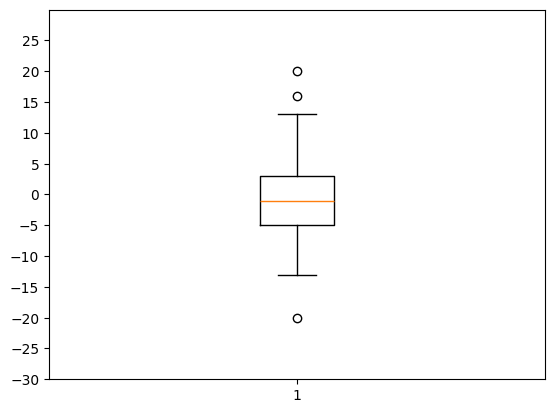

In [28]:
showMetric(intern_video_preds)

Accuracy with |error| <= 8: 0.38


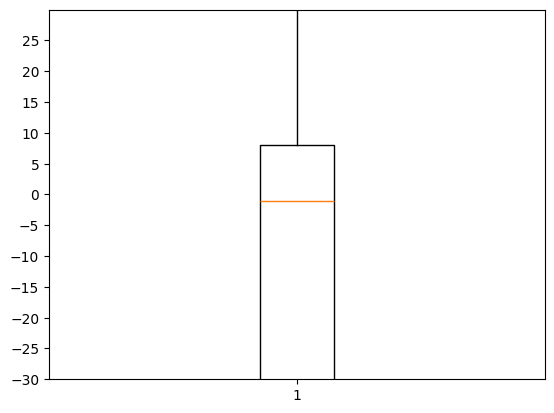

In [29]:
showMetric(clip_pred, tick = 15)

In [30]:
norm_scale = []
for video_path in tqdm([os.path.join('backflip', x) for x in os.listdir('backflip')]):
    cap = cv2.VideoCapture(video_path)

    frame_num = 0
    success, frame = cap.read()
    while success:
        frame_num += 1
        success, frame = cap.read()
    cap.release()
    
    norm_scale.append(1 / frame_num)

print(norm_scale[:5])

  0%|          | 0/50 [00:00<?, ?it/s]

[0.009433962264150943, 0.005128205128205128, 0.008264462809917356, 0.004784688995215311, 0.011363636363636364]


$$\mathbf{2}^{\text{nd}}\text{ Metric}$$
--------

In [86]:
import matplotlib.pyplot as plt
import numpy as np

# Find closest peak
def findClosest(pred, truths):
    dist = 1000000
    peak = -1
    for i in truths:
        if abs(i - pred) < dist:
            dist = abs(i - pred)
            peak = i
    return peak

def showMetric2(preds, tick = 2):
    def clamp_error(prediction, truth): # NN's Idea
        if truth in range(prediction, prediction + 9):
            return 0
        else: 
            return (prediction + 8) - truth if truth > prediction + 8 else prediction - truth
    
    mse = []
    for idx, i_pred in enumerate(preds):
        # peak = findClosest(i_pred, data[idx][1]) * norm_scale[idx]
        peak = findClosest(i_pred, data[idx][1])
        # mse.append(abs((i_pred * norm_scale[idx]) - peak)) # Calculating MAE??
        mse.append(abs(i_pred - peak)) # Calculating MAE??
    
    return mse

def find_best_offset(preds):
    total = []
    min_val = 1000
    min_result = -1
    for l in [x/100 for x in range(-3000, 3000, 1)]:
        mse = sum(showMetric2([x + l for x in preds]))
        total.append((l, mse))
        if mse < min_val:
            min_val = mse
            min_result = l
    print(min_result)

def calculateMSE(preds):
    errors = []
    for idx, i_pred in enumerate(preds):
        peak = findClosest(i_pred, data[idx][1])
        errors.append(abs(i_pred - peak)**2)
    return np.mean(errors).item()

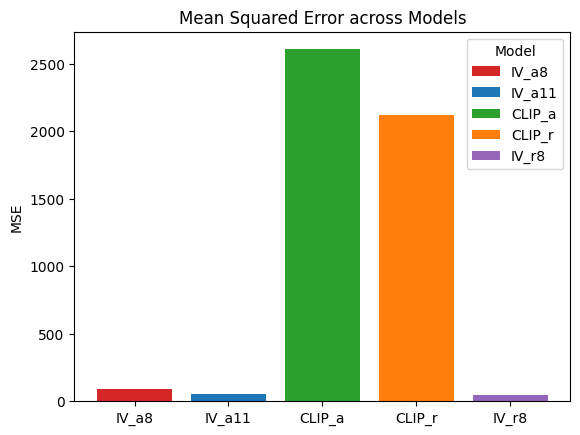

In [87]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

pred_labels = [x for x in data_load.values()]
predictions = [calculateMSE(eval(x)) for x in pred_labels]
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple']

ax.bar(pred_labels, predictions, label=pred_labels, color=bar_colors)

ax.set_ylabel('MSE')
ax.set_title('Mean Squared Error across Models')
ax.legend(title='Model')

plt.show()

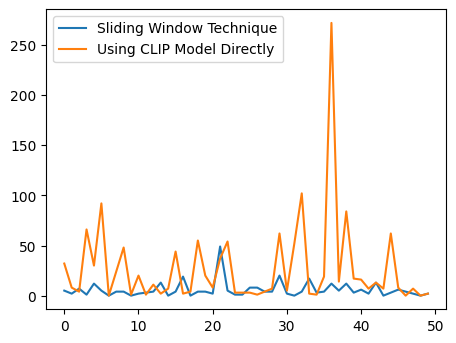

In [74]:
plt.figure(figsize=[4, 3])
plt.plot(range(50),showMetric2([x + 1 for x in IV_a8]))
plt.plot(range(50),showMetric2([x - 1 for x in CLIP_a]))

# plt.xticks(np.arange(1, 50, 1))
# plt.xlim(20, 25)
plt.legend(["Sliding Window Technique", "Using CLIP Model Directly"])
# plt.axis('off')

plt.gca().set_position([0, 0, 1, 1])
plt.savefig("output.svg", bbox_inches = "tight")
plt.show()

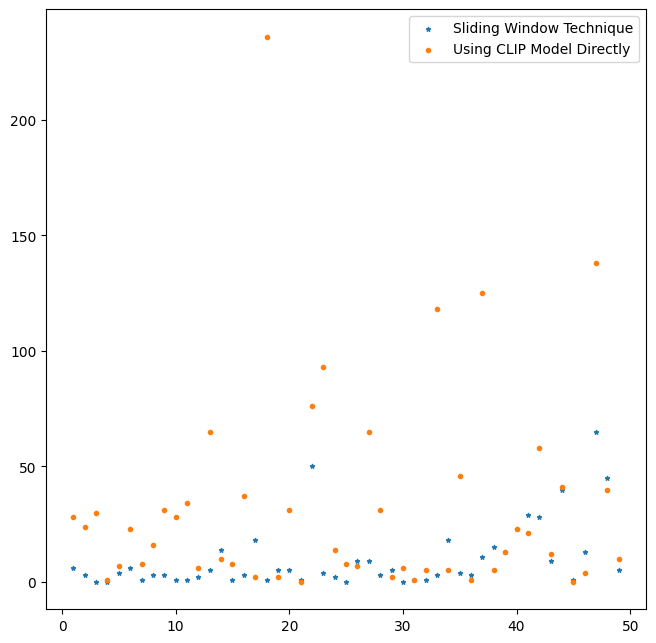

In [22]:
plt.figure(figsize=[6, 6])
plt.scatter(range(1, 50),showMetric2([x + 2 for x in cut_intern]), marker = "*", s = 9)
plt.scatter(range(1, 50),showMetric2([x - 1 for x in cut_clip]), marker='o', s = 9)
# plt.plot(range(1, 50),showMetric2([x + 2 for x in cut_intern_l]))

# plt.xticks(np.arange(1, 50, 1))
# plt.xlim(20, 30)
plt.legend(["Sliding Window Technique", "Using CLIP Model Directly"])
# plt.axis('off')

plt.gca().set_position([0, 0, 1, 1])
plt.savefig("test.svg")
plt.show()

In [44]:
intern_score = 0
clip_score   = 0
tie_score    = 0
for idx in range(len(intern_video_preds)):
    peak_intern = findClosest(intern_video_preds[idx], data[idx][1])
    peak_clip = findClosest(intern_video_preds[idx], data[idx][1])

    
    if abs(intern_video_preds[idx] - peak_intern) < abs(clip_pred[idx] - peak_clip):
        intern_score += 1
    elif abs(intern_video_preds[idx] - peak_intern) > abs(clip_pred[idx] - peak_clip):
        clip_score += 1
    else:
        tie_score += 1
print("Intern Score:",intern_score)
print("CLIP Score  :",clip_score)
print("Tied        :",tie_score)

Intern Score: 38
CLIP Score  : 8
Tied        : 4


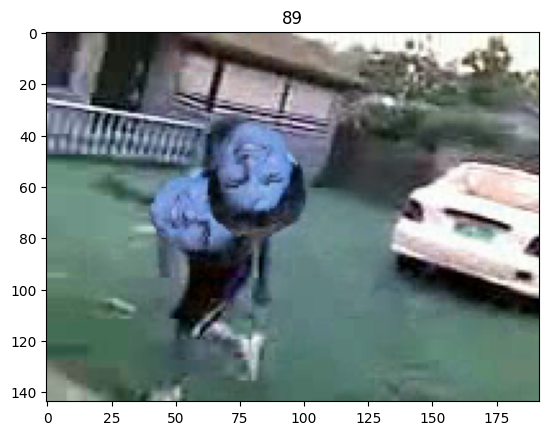

In [37]:
import cv2
import numpy as np
from PIL import Image
from IPython.display import clear_output

def load_basketball(basketball_path, size):
    basketball = Image.open(basketball_path)
    basketball = basketball.resize((size, size), Image.LANCZOS)
    return basketball

def rotate_basketball(basketball):
    random_angle = np.random.randint(0, 360)
    return basketball.rotate(random_angle, expand=True)

def add_basketball_to_frame(frame, basketball):
    frame_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    basketball_rotated = rotate_basketball(basketball)

    frame_width, frame_height = frame_pil.size
    basketball_width, basketball_height = basketball_rotated.size

    max_x = frame_width - basketball_width
    max_y = frame_height - basketball_height
    rand_x = np.random.randint(0, max_x)
    rand_y = np.random.randint(0, max_y)

    frame_pil.paste(basketball_rotated, (rand_x, rand_y), basketball_rotated)
    return cv2.cvtColor(np.array(frame_pil), cv2.COLOR_RGB2BGR)

def process_video(input_video_path, output_video_path, basketball_path, basketball_size):
    basketball = load_basketball(basketball_path, basketball_size)
    cap = cv2.VideoCapture(input_video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')

    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    count = 1
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        count += 1
        clear_output(wait=True)
        frame_with_basketball = add_basketball_to_frame(frame, basketball)

        plt.title(str(count))
        plt.imshow(frame)
        plt.show()
        out.write(frame_with_basketball)

    cap.release()
    out.release()
    cv2.destroyAllWindows()

input_video_path = 'augment/9.mp4'
output_video_path = 'augment/92.mp4'
basketball_path = 'augment_utils/cruise.png'
basketball_size = 1

process_video(input_video_path, output_video_path, basketball_path, basketball_size)